## TensorFlow Hub 사용

In [63]:
import tensorflow as tf
tf.__version__

'2.0.0'

### 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기 - 1

In [64]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install tensorflow_hub
import tensorflow_hub as hub

SyntaxError: invalid syntax (<ipython-input-65-31f10468cd25>, line 1)

In [66]:
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [67]:
# from tensorflow.keras.applications import MobileNetV2

# mobilev2 = MobileNetV2()
# tf.keras.utils.plot_model(mobilev2)

In [68]:
# mobilev2.summary()

### ImageNetV2-TopImages 불러오기

In [69]:
import os
import pathlib
# content_data_url = '/content/sample_data'  # for colab
content_data_url = '.'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

datasets\imagenetv2-topimages


In [70]:
# 디렉토리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

datasets\imagenetv2-topimages\0
datasets\imagenetv2-topimages\1
datasets\imagenetv2-topimages\10
datasets\imagenetv2-topimages\100
datasets\imagenetv2-topimages\101
datasets\imagenetv2-topimages\102
datasets\imagenetv2-topimages\103
datasets\imagenetv2-topimages\104
datasets\imagenetv2-topimages\105
datasets\imagenetv2-topimages\106


### ImageNet 라벨 텍스트 불러오기

In [71]:
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


### 이미지 확인

image_count: 10000


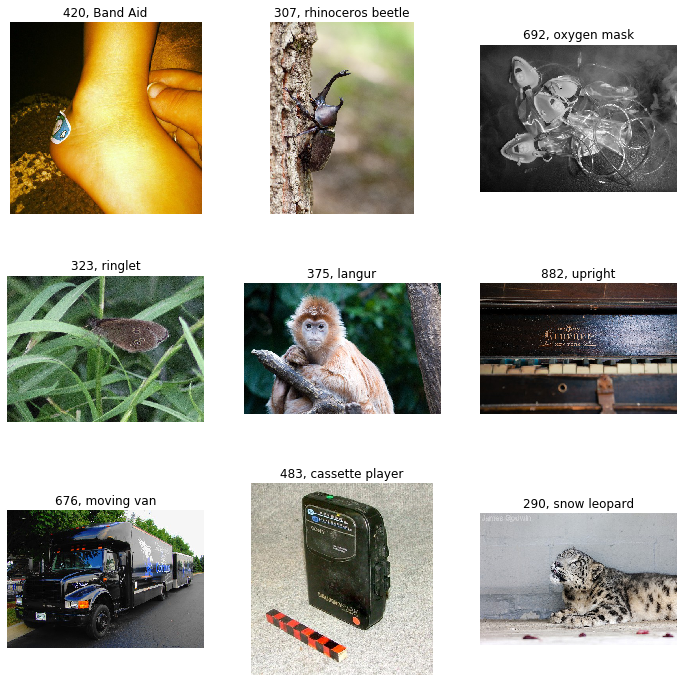

In [72]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
#     idx = int(image_path.split('/')[-2]) + 1  # for colab/linux
    idx = int(image_path.split('\\')[-2]) + 1  # for windows
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

### MobileNet의 분류 성능 확인

In [73]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [75]:
import cv2
import numpy as np

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
#     idx = int(image_path.split('/')[-2])+1  # for colab/linux
    idx = int(image_path.split('\\')[-2])+1  # for windows
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness: 83.84 %
Top-1 correctness: 59.45 %


### MobileNet의 분류 라벨 확인

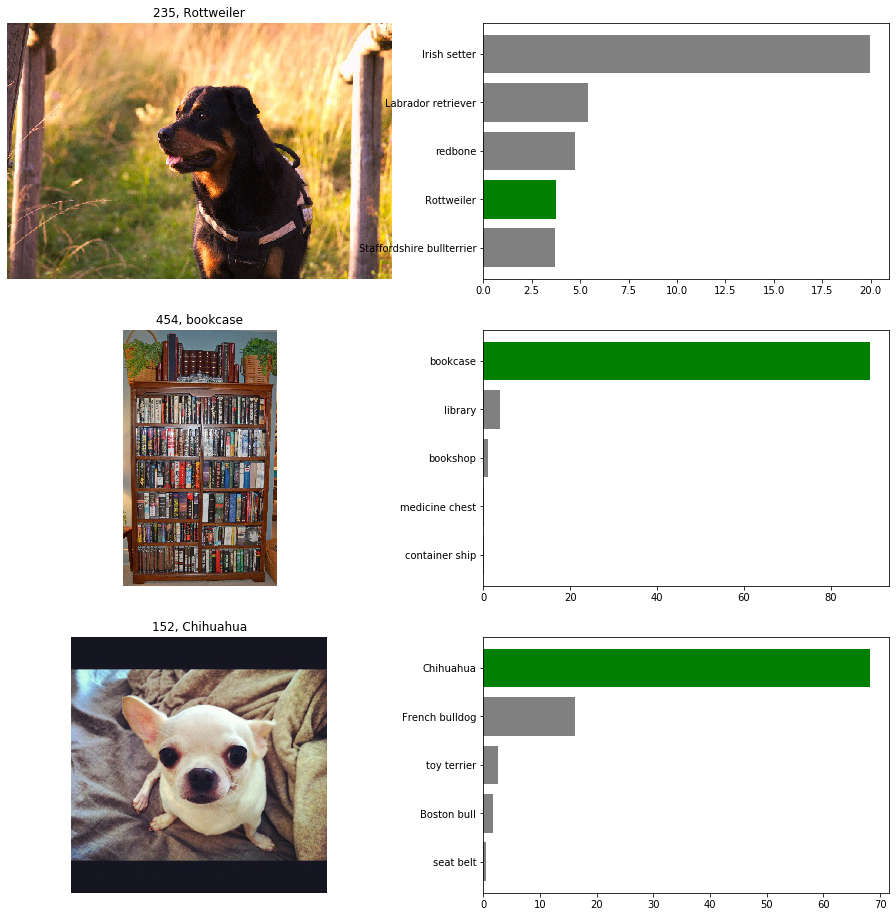

In [77]:
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
#     idx = int(image_path.split('/')[-2]) + 1  # for colab/linux
    idx = int(image_path.split('\\')[-2]) + 1  # for windows
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    

### 참고 : 텐서플로 허브에서 사전 훈련된 Embedding Layer 모델 불러오기

In [26]:
hub_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embed = hub.KerasLayer(hub_url)
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)

(3, 128) <dtype: 'float32'>


In [27]:
embeddings[0, :10]

<tf.Tensor: id=9144, shape=(10,), dtype=float32, numpy=
array([ 0.0309448 ,  0.00795427, -0.08458473,  0.09604347,  0.0084187 ,
       -0.20370951,  0.08907428,  0.069878  , -0.01948899,  0.02033026],
      dtype=float32)>

In [24]:
model = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])